# ReEDS Scenarios on PV ICE Tool USA

To explore different scenarios for furture installation projections of PV (or any technology), ReEDS output data can be useful in providing standard scenarios. ReEDS installation projections are used in this journal as input data to the PV ICE tool. 

Current sections include:

<ol>
    <li> ### Reading a standard ReEDS output file and saving it in a PV ICE input format </li>
<li>### Reading scenarios of interest and running PV ICE tool </li>
<li>###Plotting </li>
<li>### GeoPlotting.</li>
</ol>
    Notes:
   
Scenarios of Interest:
	the Ref.Mod, 
o	95-by-35.Adv, and 
o	95-by-35+Elec.Adv+DR ones


In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'TEMP' / 'Solar_Futures')
inputfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'TEMP')
print ("Your simulation will be stored in %s" % testfolder)


Your simulation will be stored in C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP\Solar_Futures


In [3]:
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [4]:
PV_ICE.__version__

'v0.2.0+28.gb7f2644.dirty'

### Reading REEDS original file to get list of SCENARIOs, PCAs, and STATEs 

In [5]:
r"""
reedsFile = str(Path().resolve().parent.parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v2a.xlsx')
print ("Input file is stored in %s" % reedsFile)

rawdf = pd.read_excel(reedsFile,
                        sheet_name="UPV Capacity (GW)")
                        #index_col=[0,2,3]) #this casts scenario, PCA and State as levels
#now set year as an index in place
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA', 'State'], inplace=True)
""";

In [6]:
#scenarios = list(rawdf.index.get_level_values('Scenario').unique())
#PCAs = list(rawdf.index.get_level_values('PCA').unique())
#STATEs = list(rawdf.index.get_level_values('State').unique())

### Create Scenarios in PV_ICE

#### Rename difficult characters from Scenarios Names

In [7]:
scenarios = ['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

In [8]:
#simulationname = scenarios
#simulationname = [w.replace('+', '_') for w in simulationname]
#simulationname

#### Downselect to Solar Future scenarios of interest

Scenarios of Interest:
<li> Ref.Mod
<li> 95-by-35.Adv  
<li> 95-by-35+Elec.Adv+DR 

In [9]:
#SFscenarios = [simulationname[0], simulationname[4], simulationname[8]]
SFscenarios = ['Reference.Mod', '95-by-35.Adv', '95-by-35_Elec.Adv_DR']
SFscenarios

['Reference.Mod', '95-by-35.Adv', '95-by-35_Elec.Adv_DR']

#### Create the 3 Scenarios and assign Baselines

Keeping track of each scenario as its own PV ICE Object.

In [10]:
#for ii in range (0, 1): #len(scenarios):
i = 0
rr = PV_ICE.Simulation(name='USA', path=testfolder)
for i in range(0, 3):
    filetitle = SFscenarios[i]+'.csv'
    filetitle = os.path.join(inputfolder, 'USA', filetitle)    
    rr.createScenario(name=SFscenarios[i], file=filetitle)
    rr.scenario[SFscenarios[i]].addMaterial('glass', file=r'..\..\baselines\SolarFutures_2021\baseline_material_glass_Reeds.csv')
    rr.scenario[SFscenarios[i]].addMaterial('silicon', file=r'..\..\baselines\SolarFutures_2021\baseline_material_silicon_Reeds.csv')
    rr.scenario[SFscenarios[i]].addMaterial('silver', file=r'..\..\baselines\SolarFutures_2021\baseline_material_silver_Reeds.csv')
    rr.scenario[SFscenarios[i]].addMaterial('copper', file=r'..\..\baselines\SolarFutures_2021\baseline_material_copper_Reeds.csv')
    rr.scenario[SFscenarios[i]].addMaterial('aluminum', file=r'..\..\baselines\SolarFutures_2021\baseline_material_aluminium_Reeds.csv')


path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP\Solar_Futures


# 2 FINISH: Set characteristics of Recycling to SF values.

#### Calculate Mass Flow

In [11]:
IRENA= False
PERFECTMFG = True

mats = ['glass', 'silicon','silver','copper','aluminum']

ELorRL = 'EL'
if IRENA:
    if ELorRL == 'RL':
        weibullInputParams = {'alpha': 5.3759, 'beta':30}  # Regular-loss scenario IRENA
    if ELorRL == 'EL':
        weibullInputParams = {'alpha': 2.49, 'beta':30}  # Regular-loss scenario IRENA
    
    if PERFECTMFG:
        for jj in range (0, len(rr.scenario.keys())):
            rr.scenario[list(rr.scenario.keys())[jj]].data['mod_lifetime'] = 40
            rr.scenario[list(rr.scenario.keys())[jj]].data['mod_MFG_eff'] = 100.0

            for kk in range(0, len(mats)):
                mat = mats[kk]
                rr.scenario[list(rr.scenario.keys())[jj]].material[mat].materialdata['mat_MFG_eff'] = 100.0   
                rr.scenario[list(rr.scenario.keys())[jj]].material[mat].materialdata['mat_MFG_scrap_Recycled'] = 0.0   
               
    
    rr.calculateMassFlow(weibullInputParams=weibullInputParams)
    title_Method = 'Irena_'+ELorRL
else:
    rr.calculateMassFlow()
    title_Method = 'PVICE'


Working on Scenario:  Reference.Mod
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  95-by-35.Adv
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  95-by-35_Elec.Adv_DR
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum


In [12]:
print("Scenarios:", rr.scenario.keys())
print("Module Keys:", rr.scenario[SFscenarios[0]].data.keys())
print("Material Keys: ", rr.scenario[SFscenarios[0]].material['glass'].materialdata.keys())

Scenarios: dict_keys(['Reference.Mod', '95-by-35.Adv', '95-by-35_Elec.Adv_DR'])
Module Keys: Index(['year', 'new_Installed_Capacity_[MW]', 'mod_eff', 'mod_reliability_t50',
       'mod_reliability_t90', 'mod_degradation', 'mod_lifetime', 'mod_MFG_eff',
       'mod_EOL_collection_eff', 'mod_EOL_collected_recycled', 'mod_Repair',
       'mod_MerchantTail', 'mod_Reuse', 'irradiance_stc', 'Area',
       'Cumulative_Area_disposedby_Failure',
       'Cumulative_Area_disposedby_ProjectLifetime',
       'Cumulative_Area_disposed', 'Repaired_[W]', 'Repaired_Area',
       'Cumulative_Active_Area', 'Installed_Capacity_[W]', 'WeibullParams',
       'EOL_on_Year_0', 'EOL_on_Year_1', 'EOL_on_Year_2', 'EOL_on_Year_3',
       'EOL_on_Year_4', 'EOL_on_Year_5', 'EOL_on_Year_6', 'EOL_on_Year_7',
       'EOL_on_Year_8', 'EOL_on_Year_9', 'EOL_on_Year_10', 'EOL_on_Year_11',
       'EOL_on_Year_12', 'EOL_on_Year_13', 'EOL_on_Year_14', 'EOL_on_Year_15',
       'EOL_on_Year_16', 'EOL_on_Year_17', 'EOL_on_Year_

In [13]:
"""
r1.plotScenariosComparison(keyword='Cumulative_Area_disposedby_Failure')
r1.plotMaterialComparisonAcrossScenarios(material='silicon', keyword='mat_Total_Landfilled')
"""
pass

## Aggregating PCAs Material Landfilled to obtain US totals by Year

In [14]:
USyearly=pd.DataFrame()

In [15]:
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

In [16]:
keywd = 'mat_Virgin_Stock'

for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    for ii in range(len(materials)):
        USyearly['VirginStock_'+materials[ii]+'_'+obj] = rr.scenario[obj].material[materials[ii]].materialdata[keywd]

    filter_col = [col for col in USyearly if (col.startswith('VirginStock_') and col.endswith(obj))]
    USyearly['VirginStock_Module_'+obj] = USyearly[filter_col].sum(axis=1)

In [17]:
keywd = 'mat_Total_Landfilled'

for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    for ii in range(len(materials)):
        USyearly['Waste_'+materials[ii]+'_'+obj] = rr.scenario[obj].material[materials[ii]].materialdata[keywd]

    filter_col = [col for col in USyearly if (col.startswith('Waste_') and col.endswith(obj)) ]
    USyearly['Waste_Module_'+obj] = USyearly[filter_col].sum(axis=1)

In [18]:
keywd = 'mat_Total_EOL_Landfilled'

for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    for ii in range(len(materials)):
        USyearly['Waste_EOL_'+materials[ii]+'_'+obj] = rr.scenario[obj].material[materials[ii]].materialdata[keywd]

    filter_col = [col for col in USyearly if (col.startswith('Waste_EOL_') and col.endswith(obj)) ]
    USyearly['Waste_EOL_Module_'+obj] = USyearly[filter_col].sum(axis=1)

In [19]:
keywd = 'mat_Total_MFG_Landfilled'

for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    for ii in range(len(materials)):
        USyearly['Waste_MFG_'+materials[ii]+'_'+obj] = rr.scenario[obj].material[materials[ii]].materialdata[keywd]

    filter_col = [col for col in USyearly if (col.startswith('Waste_MFG_') and col.endswith(obj)) ]
    USyearly['Waste_MFG_Module_'+obj] = USyearly[filter_col].sum(axis=1)

### Converting to grams to METRIC Tons. 


In [20]:
USyearly = USyearly/1000000  # This is the ratio for Metric tonnes
#907185 -- this is for US tons


### Adding NEW Installed Capacity to US

In [21]:
keyword='new_Installed_Capacity_[MW]'
for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    USyearly[keyword+obj] = rr.scenario[obj].data[keyword]
 

#### Reindexing and creating c umulative results

In [22]:
UScum = USyearly.copy()
UScum = UScum.cumsum()

### Adding Installed Capacity to US (This is already 'Cumulative') so not including it in UScum

In [23]:
keyword='Installed_Capacity_[W]'
for jj in range(len(SFscenarios)):
    obj = SFscenarios[jj]
    USyearly["Capacity_"+obj] = rr.scenario[obj].data[keyword]
 

#### Set YEAR Index

In [24]:
USyearly.index = rr.scenario[obj].data['year']
UScum.index = rr.scenario[obj].data['year']

In [25]:
USyearly.head().iloc[1]

VirginStock_glass_Reference.Mod                    1.442186e+05
VirginStock_silicon_Reference.Mod                  1.445687e+04
VirginStock_silver_Reference.Mod                   2.199155e+02
VirginStock_copper_Reference.Mod                   1.022991e+02
VirginStock_aluminum_Reference.Mod                 3.402000e+04
                                                       ...     
new_Installed_Capacity_[MW]95-by-35.Adv            2.534300e+03
new_Installed_Capacity_[MW]95-by-35_Elec.Adv_DR    2.534300e+03
Capacity_Reference.Mod                             3.751735e+09
Capacity_95-by-35.Adv                              3.751735e+09
Capacity_95-by-35_Elec.Adv_DR                      3.751735e+09
Name: 2011, Length: 78, dtype: float64

In [26]:
USyearly.head()

,VirginStock_glass_Reference.Mod,VirginStock_silicon_Reference.Mod,VirginStock_silver_Reference.Mod,VirginStock_copper_Reference.Mod,VirginStock_aluminum_Reference.Mod,VirginStock_Module_Reference.Mod,VirginStock_glass_95-by-35.Adv,VirginStock_silicon_95-by-35.Adv,VirginStock_silver_95-by-35.Adv,VirginStock_copper_95-by-35.Adv,...,Waste_MFG_silver_95-by-35_Elec.Adv_DR,Waste_MFG_copper_95-by-35_Elec.Adv_DR,Waste_MFG_aluminum_95-by-35_Elec.Adv_DR,Waste_MFG_Module_95-by-35_Elec.Adv_DR,new_Installed_Capacity_[MW]Reference.Mod,new_Installed_Capacity_[MW]95-by-35.Adv,new_Installed_Capacity_[MW]95-by-35_Elec.Adv_DR,Capacity_Reference.Mod,Capacity_95-by-35.Adv,Capacity_95-by-35_Elec.Adv_DR
year,,,,,,,,,,,,,,,,,,,,,
2010,70184.285787,7082.020411,128.426774,49.784053,16728.966195,94173.483221,70184.285787,7082.020411,128.426774,49.784053,...,27.740183,5.874518,498.523193,9032.812399,1200.651350,1200.651350,1200.651350,1.208819e+09,1.208819e+09,1.208819e+09
2011,144218.641713,14456.874009,219.915502,102.299090,34020.002590,193017.732904,144218.641713,14456.874009,219.915502,102.299090,...,47.501748,12.071293,1013.796077,18445.373832,2534.300109,2534.300109,2534.300109,3.751735e+09,3.751735e+09,3.751735e+09
2012,142823.279530,14473.896289,172.505147,100.306250,33296.094628,190866.081844,142823.279530,14473.896289,172.505147,100.306250,...,37.261112,11.836138,992.223620,18471.131942,2534.300109,2534.300109,2534.300109,6.282106e+09,6.282106e+09,6.282106e+09
2013,280638.797333,27437.479671,234.947057,195.163190,53446.058911,361952.446162,280638.720044,27437.472114,234.946992,195.163136,...,50.748550,23.029250,1592.692117,35045.028655,5123.033732,5123.032321,5123.032321,1.140951e+10,1.140951e+10,1.140951e+10
2014,279365.351489,26818.242077,214.149815,191.571229,51596.845772,358186.160382,279365.274550,26818.234691,214.149756,191.571176,...,46.256347,22.605399,1537.585581,33977.393769,5123.033732,5123.032321,5123.032321,1.651318e+10,1.651318e+10,1.651318e+10


In [27]:
UScum.head()

,VirginStock_glass_Reference.Mod,VirginStock_silicon_Reference.Mod,VirginStock_silver_Reference.Mod,VirginStock_copper_Reference.Mod,VirginStock_aluminum_Reference.Mod,VirginStock_Module_Reference.Mod,VirginStock_glass_95-by-35.Adv,VirginStock_silicon_95-by-35.Adv,VirginStock_silver_95-by-35.Adv,VirginStock_copper_95-by-35.Adv,...,Waste_MFG_Module_95-by-35.Adv,Waste_MFG_glass_95-by-35_Elec.Adv_DR,Waste_MFG_silicon_95-by-35_Elec.Adv_DR,Waste_MFG_silver_95-by-35_Elec.Adv_DR,Waste_MFG_copper_95-by-35_Elec.Adv_DR,Waste_MFG_aluminum_95-by-35_Elec.Adv_DR,Waste_MFG_Module_95-by-35_Elec.Adv_DR,new_Installed_Capacity_[MW]Reference.Mod,new_Installed_Capacity_[MW]95-by-35.Adv,new_Installed_Capacity_[MW]95-by-35_Elec.Adv_DR
year,,,,,,,,,,,,,,,,,,,,,
2010,70184.285787,7082.020411,128.426774,49.784053,16728.966195,9.417348e+04,70184.285787,7082.020411,128.426774,49.784053,...,9032.812399,4842.715719,3657.958785,27.740183,5.874518,498.523193,9032.812399,1200.651350,1200.651350,1200.651350
2011,214402.927500,21538.894420,348.342276,152.083143,50748.968785,2.871912e+05,214402.927500,21538.894420,348.342276,152.083143,...,27478.186231,14793.801998,11078.877221,75.241932,17.945811,1512.319270,27478.186231,3734.951459,3734.951459,3734.951459
2012,357226.207030,36012.790709,520.847423,252.389394,84045.063413,4.780573e+05,357226.207030,36012.790709,520.847423,252.389394,...,45949.318172,24648.608285,18653.882006,112.503043,29.781948,2504.542890,45949.318172,6269.251568,6269.251568,6269.251568
2013,637865.004364,63450.270380,755.794480,447.552583,137491.122324,8.400097e+05,637864.927074,63450.262823,755.794415,447.552530,...,80994.346827,44012.679968,32668.369060,163.251594,52.811199,4097.235007,80994.346827,11392.285299,11392.283888,11392.283888
2014,917230.355853,90268.512456,969.944295,639.123813,189087.968095,1.198196e+06,917230.201624,90268.497514,969.944172,639.123706,...,114971.740596,62741.327974,46310.667497,209.507941,75.416597,5634.820587,114971.740596,16515.319031,16515.316209,16515.316209


### 3 sig figures save Yearly and cumulative overview Nation

In [28]:
# Data for Jarett
USyearly.to_csv(title_Method+' US_Yearly NATION_tonnes.csv')
UScum.to_csv(title_Method+' US_Cumulative NATION_tonnes.csv')


In [29]:
USyearly3sig = USyearly.copy()
UScum3sig = UScum.copy()
N = 2

UScum3sig = UScum3sig.drop(UScum3sig.index[0])
USyearly3sig = USyearly3sig.drop(USyearly3sig.index[0])

if IRENA:
    UScum3sig = UScum3sig.loc[:, ~UScum3sig.columns.str.startswith('Waste_MFG_')]
    USyearly3sig = USyearly3sig.loc[:, ~USyearly3sig.columns.str.startswith('Waste_MFG_')]

USyearly3sig = USyearly3sig.applymap(lambda x: round(x, N - int(np.floor(np.log10(abs(x))))))
USyearly3sig = USyearly3sig.applymap(lambda x: int(x))

UScum3sig = UScum3sig.applymap(lambda x: round(x, N - int(np.floor(np.log10(abs(x))))))
UScum3sig = UScum3sig.applymap(lambda x: int(x))

USyearly3sig.to_csv(title_Method+' US_Yearly NATION_3sigs.csv')
UScum3sig.to_csv(title_Method+' US_Cumulative NATION_3sigs.csv')


In [30]:
print("Sanity check: mat_Total_Landfilled = mat_Total_EOL_Landfilled + mat_Total_MFG_Landfilled")
A = rr.scenario[obj].material[materials[ii]].materialdata['mat_Total_Landfilled'].iloc[5]
B = rr.scenario[obj].material[materials[ii]].materialdata['mat_Total_EOL_Landfilled'].iloc[5]
C = rr.scenario[obj].material[materials[ii]].materialdata['mat_Total_MFG_Landfilled'].iloc[5]
A - B - C

Sanity check: mat_Total_Landfilled = mat_Total_EOL_Landfilled + mat_Total_MFG_Landfilled


0.0

# PLOT

## Yearly Virgin Material Needs by Scenario

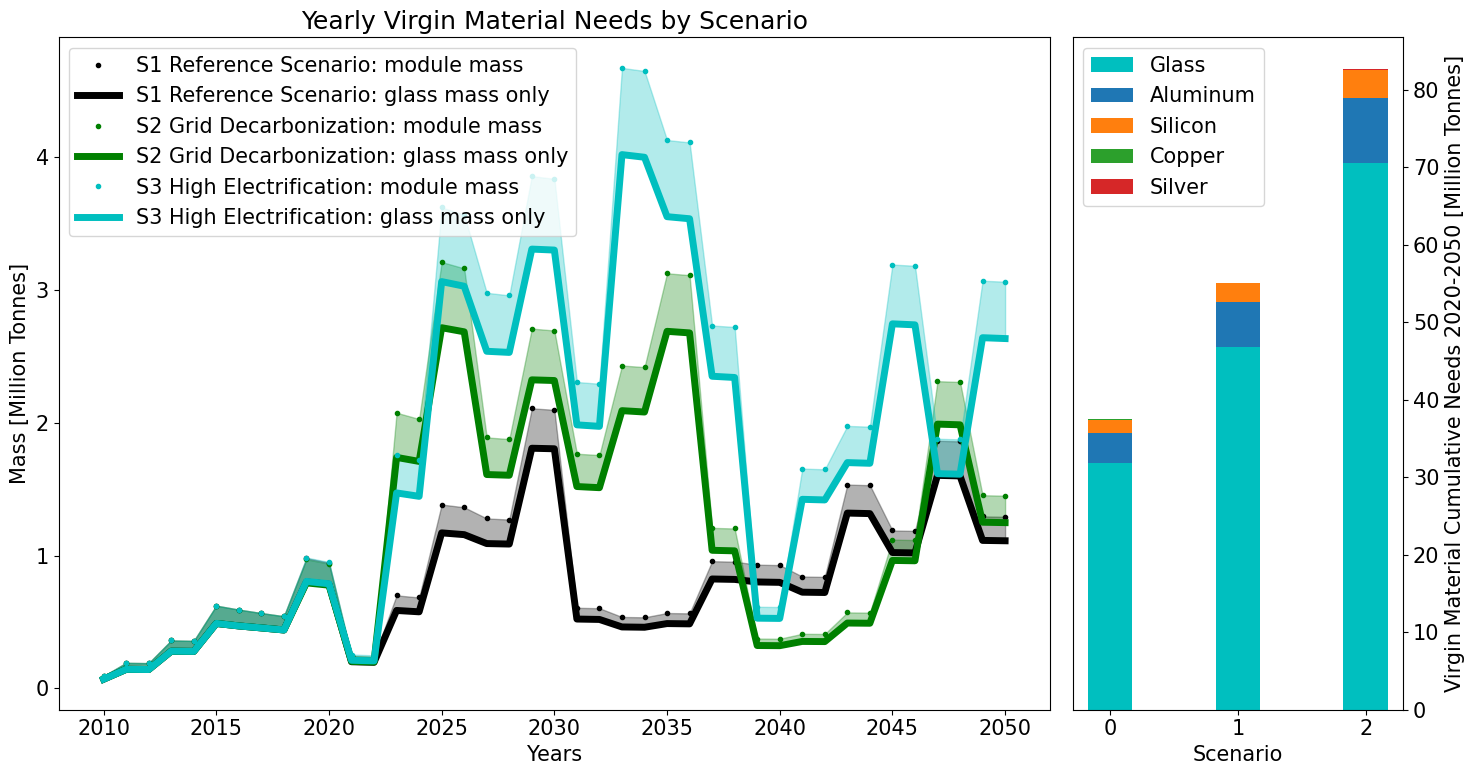

In [34]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################

foo = pd.DataFrame() 
    
# Loop over Keywords
ii = 0 
# Loop over SF Scenarios

# loop plotting over scenarios

# SCENARIO 1 ***************
kk = 0
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'k.', linewidth=5, label='S1 Reference Scenario: module mass')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'k', linewidth=5, label='S1 Reference Scenario: glass mass only')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)


# SCENARIO 2 ***************
kk = 1
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'g.', linewidth=5, label='S2 Grid Decarbonization: module mass')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'g', linewidth=5, label='S2 Grid Decarbonization: glass mass only')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='g', alpha=0.3,
                 interpolate=True)

# SCENARIO 3 ***************
kk = 2
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'c.', linewidth=5, label='S3 High Electrification: module mass')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'c', linewidth=5, label='S3 High Electrification: glass mass only')

a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly Virgin Material Needs by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')

a0.set_xlabel('Years')



    
########################    
# SUBPLOT 2
########################
#######################
# Calculate    
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    for kk in range (0, 3):
        obj = SFscenarios[kk]
        matcum.append(UScum[keyw+materials[ii]+'_'+obj].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminum']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(3)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminum'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Virgin Material Cumulative Needs 2020-2050 [Million Tonnes]')
a1.set_xlabel('Scenario')
#a1.set_xticks(ind, ('S1', 'S2', 'S3'))
#plt.yticks(np.arange(0, 81, 10))
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0] ), ('Glass', 'Aluminum', 'Silicon','Copper','Silver'))

f.tight_layout()

f.savefig(title_Method+' Fig_2x1_Yearly Virgin Material Needs by Scenario and Cumulatives.png', dpi=600)
plt.show()

In [35]:
rr.scenario['Reference.Mod'].material['glass'].materialdata['mat_Virgin_Stock'].tail(5)

36    1.021035e+12
37    1.605191e+12
38    1.601007e+12
39    1.115273e+12
40    1.112549e+12
Name: mat_Virgin_Stock, dtype: float64

# Save Data for Jarett Zuboy

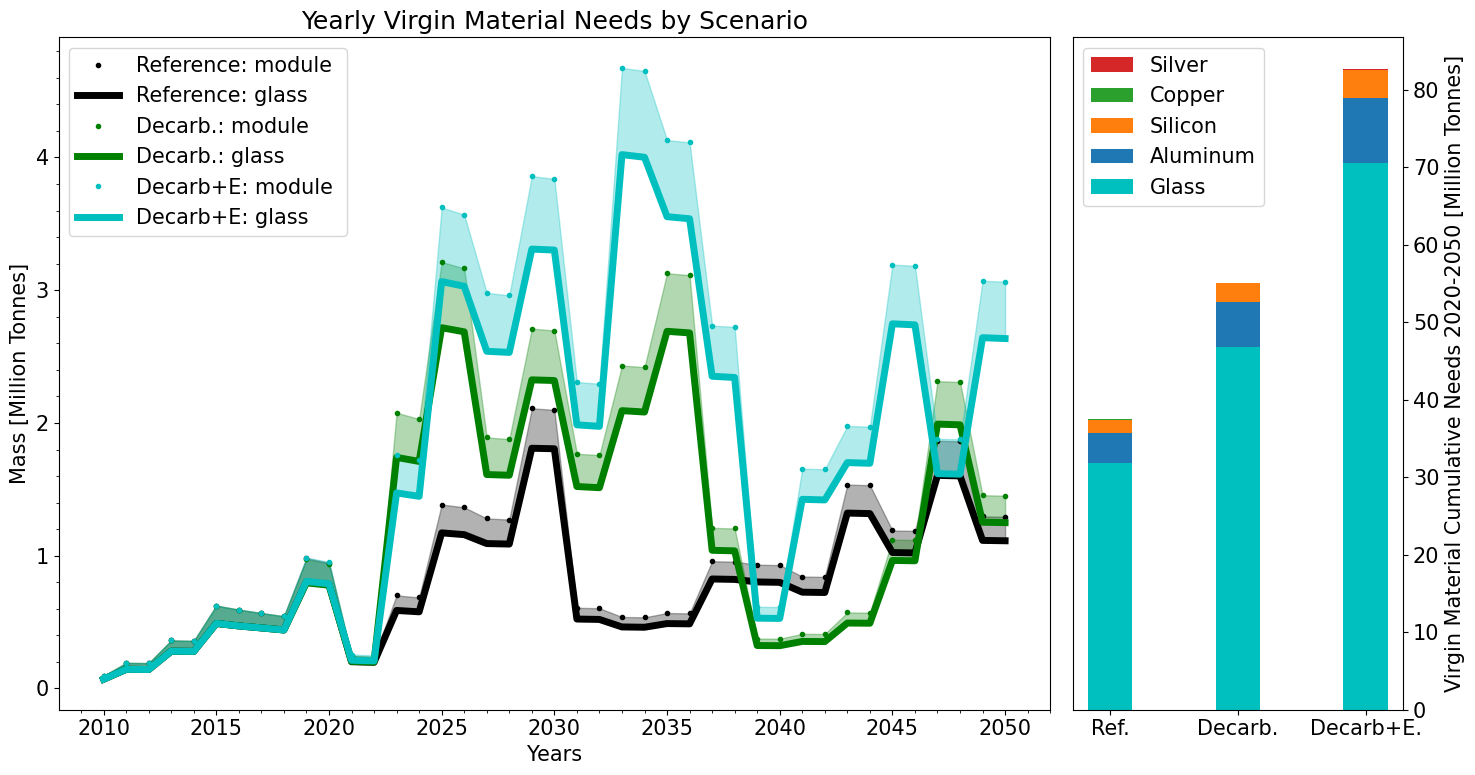

In [41]:
# SOLAR FUTURES FIGURE 3
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################

    
    
# Loop over Keywords
ii = 0 
# Loop over SF Scenarios

# loop plotting over scenarios

# SCENARIO 1 ***************
kk = 0
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'k.', linewidth=5, label='Reference: module ')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'k', linewidth=5, label='Reference: glass ')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
kk = 1
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'g.', linewidth=5, label='Decarb.: module ')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'g', linewidth=5, label='Decarb.: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='g', alpha=0.3,
                 interpolate=True)

# SCENARIO 3 ***************
kk = 2
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'c.', linewidth=5, label='Decarb+E: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'c', linewidth=5, label='Decarb+E: glass')

a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend(loc='upper left')
a0.set_title('Yearly Virgin Material Needs by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')

a0.set_xlabel('Years')
#a0.tick_params(axis='y', which='minor', length=3)
#a0.set_yticks(minorbool=True) 
a0.minorticks_on()
a0.tick_params(axis='y', which='minor', bottom=False)
    
    
########################    
# SUBPLOT 2
########################
#######################
# Calculate    
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    for kk in range (0, 3):
        obj = SFscenarios[kk]
        matcum.append(UScum[keyw+materials[ii]+'_'+obj].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminum']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(3)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminum'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Virgin Material Cumulative Needs 2020-2050 [Million Tonnes]')
#a1.set_xlabel('Scenario')
a1.tick_params(axis='y', which='minor', bottom='off')
#a1.minorticks_on()

plt.sca(a1)
plt.xticks(range(3), ['Ref.', 'Decarb.', 'Decarb+E.'], color='black', rotation=0)
plt.tick_params(axis='y', which='minor', bottom=False)
#plt.yticks(minor=True)
a1.legend((p4[0], p3[0], p2[0], p1[0], p0[0] ), ('Silver', 'Copper', 'Silicon','Aluminum','Glass'))

f.tight_layout()

f.savefig(title_Method+' SF Figure 3 - Yearly Virgin Material Needs by Scenario and Cumulatives.png', dpi=600)
plt.show()

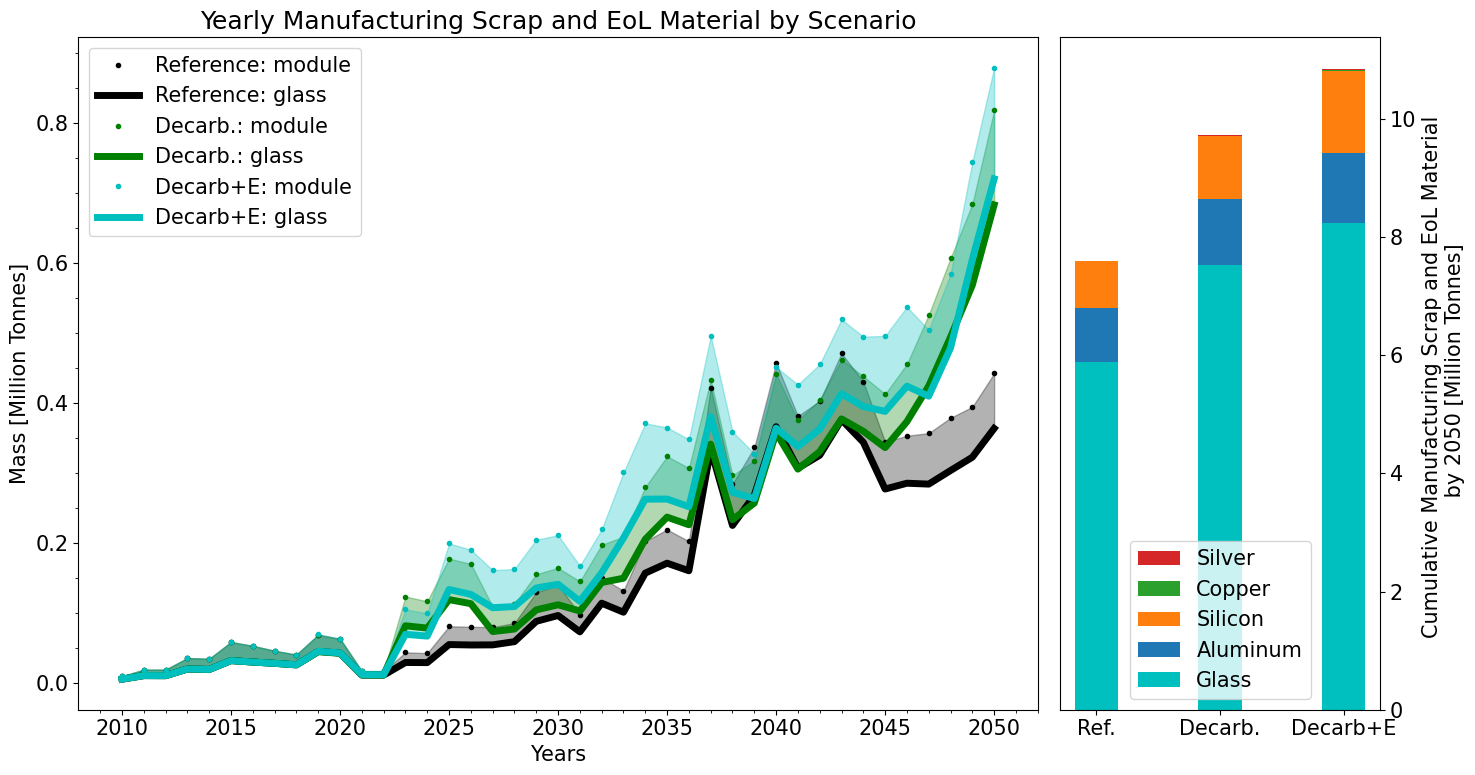

In [45]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)

keyw='Waste_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################

    
    
# Loop over Keywords
ii = 0 
# Loop over SF Scenarios

# loop plotting over scenarios

# SCENARIO 1 ***************
kk = 0
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'k.', linewidth=5, label='Reference: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'k', linewidth=5, label='Reference: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
kk = 1
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'g.', linewidth=5, label='Decarb.: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'g', linewidth=5, label='Decarb.: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='g', alpha=0.3,
                 interpolate=True)

# SCENARIO 3 ***************
kk = 2
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'c.', linewidth=5, label='Decarb+E: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'c', linewidth=5, label='Decarb+E: glass')

a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly Manufacturing Scrap and EoL Material by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')

a0.set_xlabel('Years')
a0.minorticks_on()
a0.tick_params(axis='y', which='minor', bottom=False)


    
########################    
# SUBPLOT 2
########################
#######################
# Calculate    
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    for kk in range (0, 3):
        obj = SFscenarios[kk]
        matcum.append(UScum[keyw+materials[ii]+'_'+obj].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminum']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(3)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminum'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Cumulative Manufacturing Scrap and EoL Material \n by 2050 [Million Tonnes]')

plt.sca(a1)
plt.xticks(range(3), ['Ref.', 'Decarb.', 'Decarb+E'], color='black', rotation=0)
plt.tick_params(axis='y', which='minor', bottom=False)
#plt.yticks(minor=True)
a1.legend((p4[0], p3[0], p2[0], p1[0], p0[0] ), ('Silver', 'Copper', 'Silicon','Aluminum','Glass'))



f.tight_layout()

f.savefig(title_Method+' Fig_2x1_Yearly MFG and EOL Material by Scenario and Cumulatives_Nation.png', dpi=600)
plt.show()

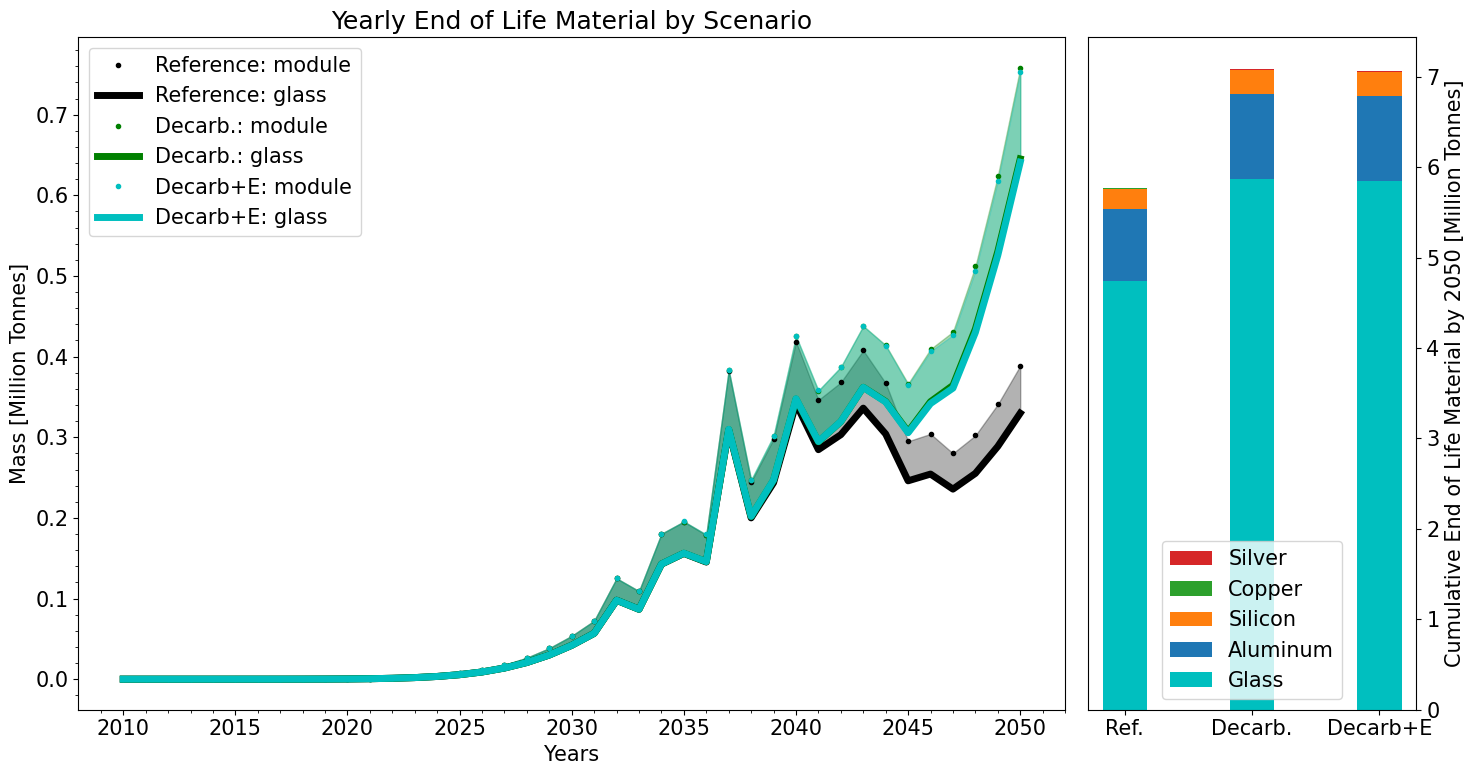

In [86]:
# SOLAR FUTURES FIGURE 17

plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='Waste_EOL_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################

    
    
# Loop over Keywords
ii = 0 
# Loop over SF Scenarios

# loop plotting over scenarios

# SCENARIO 1 ***************
kk = 0
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'k.', linewidth=5, label='Reference: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'k', linewidth=5, label='Reference: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
kk = 1
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'g.', linewidth=5, label='Decarb.: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'g', linewidth=5, label='Decarb.: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='g', alpha=0.3,
                 interpolate=True)

# SCENARIO 3 ***************
kk = 2
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'c.', linewidth=5, label='Decarb+E: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'c', linewidth=5, label='Decarb+E: glass ')

a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly End of Life Material by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')

a0.set_xlabel('Years')
a0.minorticks_on()
a0.tick_params(axis='y', which='minor', bottom=False)




    
########################    
# SUBPLOT 2
########################
#######################
# Calculate    
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    for kk in range (0, 3):
        obj = SFscenarios[kk]
        matcum.append(UScum[keyw+materials[ii]+'_'+obj].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminum']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(3)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminum'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Cumulative End of Life Material by 2050 [Million Tonnes]')

plt.sca(a1)
plt.xticks(range(3), ['Ref.', 'Decarb.', 'Decarb+E'], color='black', rotation=0)
plt.tick_params(axis='y', which='minor', bottom=False)
#plt.yticks(minor=True)
a1.legend((p4[0], p3[0], p2[0], p1[0], p0[0] ), ('Silver', 'Copper', 'Silicon','Aluminum','Glass'))



f.tight_layout()

f.savefig(title_Method+' SF Figure 17 - Yearly EoL Waste by Scenario and Cumulatives_Nation.png', dpi=600)

plt.show()

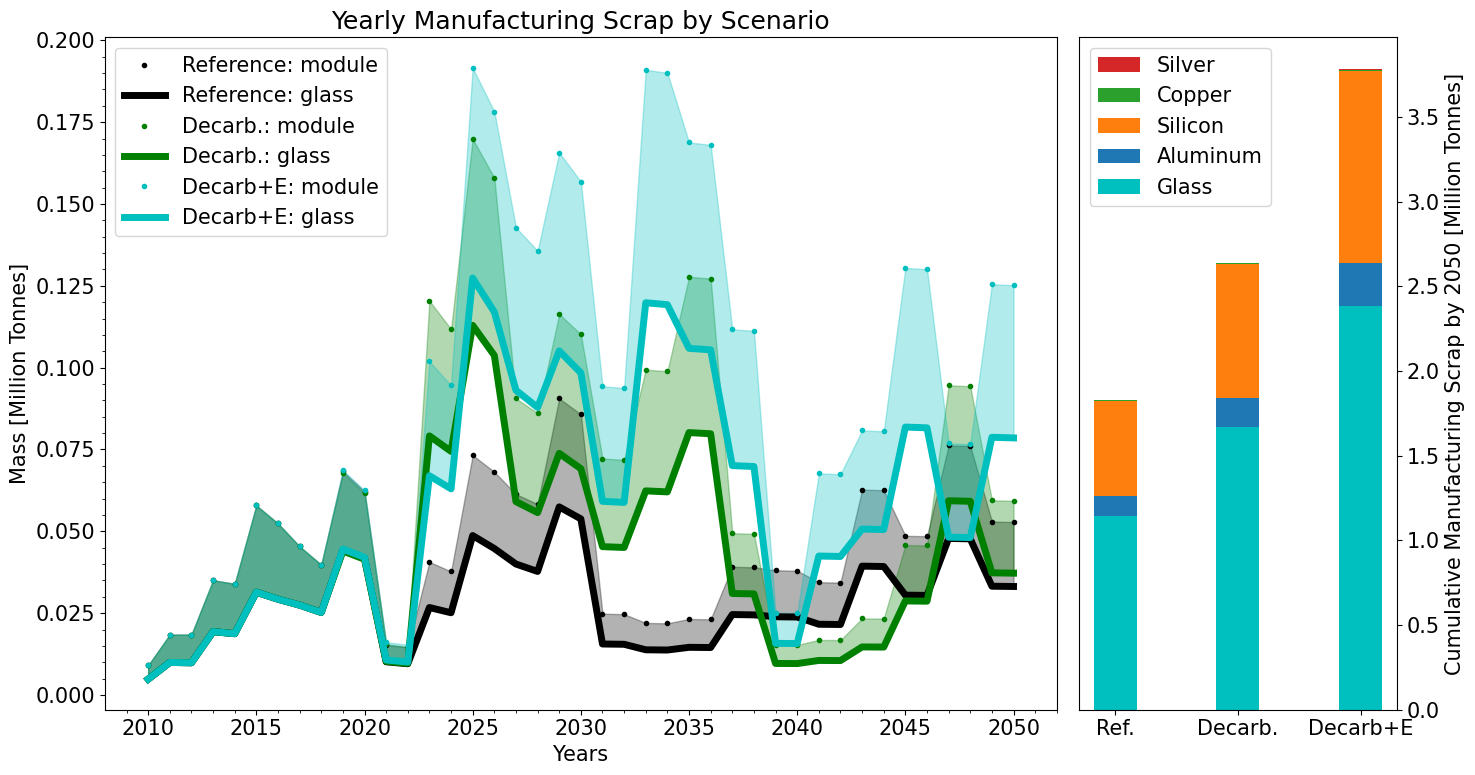

In [88]:
### SOLAR FUTURES FIGURE 18
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='Waste_MFG_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################

    
    
# Loop over Keywords
ii = 0 
# Loop over SF Scenarios

# loop plotting over scenarios

# SCENARIO 1 ***************
kk = 0
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'k.', linewidth=5, label='Reference: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'k', linewidth=5, label='Reference: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
kk = 1
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'g.', linewidth=5, label='Decarb.: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'g', linewidth=5, label='Decarb.: glass')
a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='g', alpha=0.3,
                 interpolate=True)

# SCENARIO 3 ***************
kk = 2
obj = SFscenarios[kk]

modulemat = (USyearly[keyw+materials[0]+'_'+obj]+USyearly[keyw+materials[1]+'_'+obj]+
            USyearly[keyw+materials[2]+'_'+obj]+USyearly[keyw+materials[3]+'_'+obj]+
            USyearly[keyw+materials[4]+'_'+obj])
glassmat = (USyearly[keyw+materials[0]+'_'+obj])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(rr.scenario[obj].data['year'], modulemat, 'c.', linewidth=5, label='Decarb+E: module')
a0.plot(rr.scenario[obj].data['year'], glassmat, 'c', linewidth=5, label='Decarb+E: glass')

a0.fill_between(rr.scenario[obj].data['year'], glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend(loc='upper left')
a0.set_title('Yearly Manufacturing Scrap by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')

a0.set_xlabel('Years')
a0.minorticks_on()
a0.tick_params(axis='y', which='minor', bottom=False)




    
########################    
# SUBPLOT 2
########################
#######################
# Calculate    
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    for kk in range (0, 3):
        obj = SFscenarios[kk]
        matcum.append(UScum[keyw+materials[ii]+'_'+obj].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminum']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(3)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminum'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Cumulative Manufacturing Scrap by 2050 [Million Tonnes]')

plt.sca(a1)
plt.xticks(range(3), ['Ref.', 'Decarb.', 'Decarb+E'], color='black', rotation=0)
plt.tick_params(axis='y', which='minor', bottom=False)
#plt.yticks(minor=True)
a1.legend((p4[0], p3[0], p2[0], p1[0], p0[0] ), ('Silver', 'Copper', 'Silicon','Aluminum','Glass'))



f.tight_layout()

f.savefig(title_Method+' SF Figure 18 - Yearly MFG Waste by Scenario and Cumulatives_Nation.png', dpi=600)
plt.show()

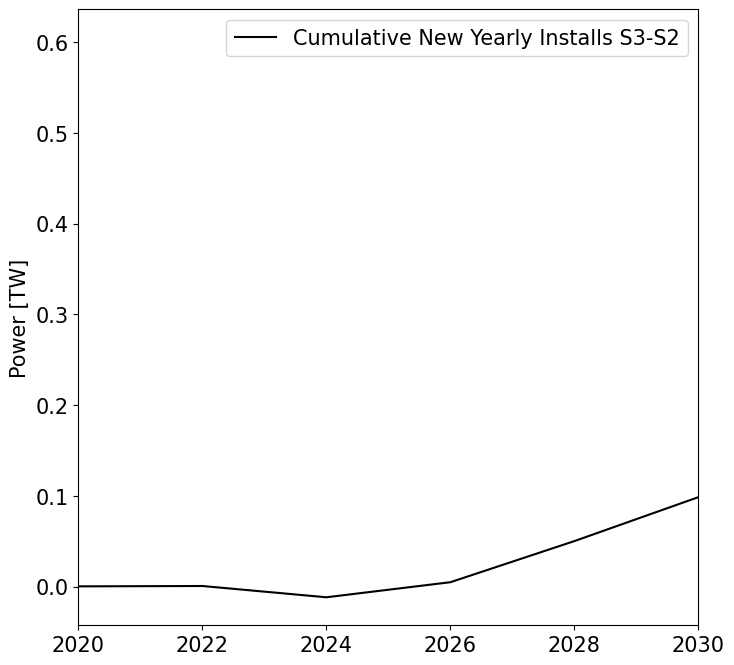

In [50]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 8)

fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6-UScum['new_Installed_Capacity_[MW]'+SFscenarios[1]]/1e6, 'k', label='Cumulative New Yearly Installs S3-S2')

#axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6, 'c', label='Cumulative New Yearly Installs')

axs.legend()
axs.set_xlim([2020,2030])
axs.set_ylabel('Power [TW]')
fig.savefig(title_Method+' Fig_New_Installs_vs_InstalledCapacity_vs_Waste', dpi=600)
plt.show()

# WASTE COMPARISON SIZE

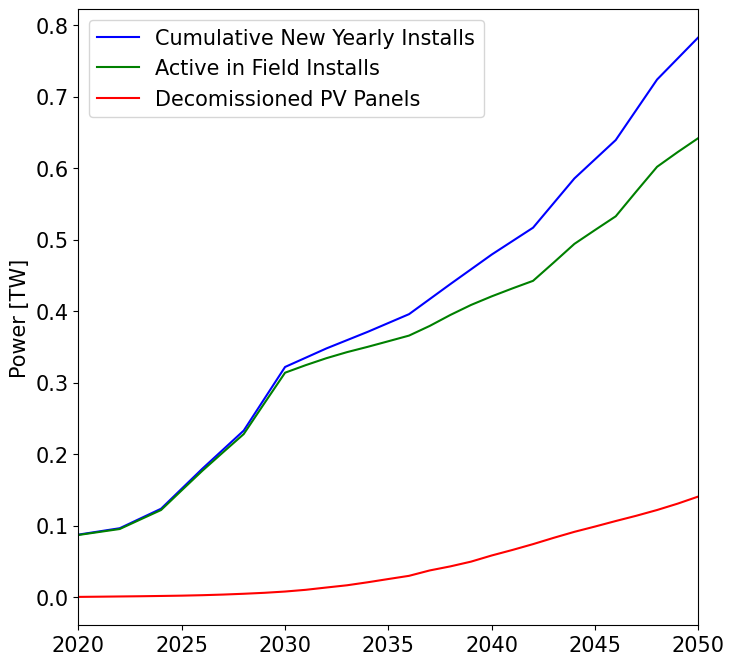

In [53]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 8)

fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6, 'b', label='Cumulative New Yearly Installs')
axs.plot(USyearly['Capacity_'+SFscenarios[0]]/1e12, 'g', label='Active in Field Installs')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12, 'r', label='Decomissioned PV Panels')
axs.legend()
axs.set_xlim([2020,2050])
axs.set_ylabel('Power [TW]')
fig.savefig(title_Method+' Fig_New_Installs_vs_InstalledCapacity_vs_Waste', dpi=600)
plt.show()

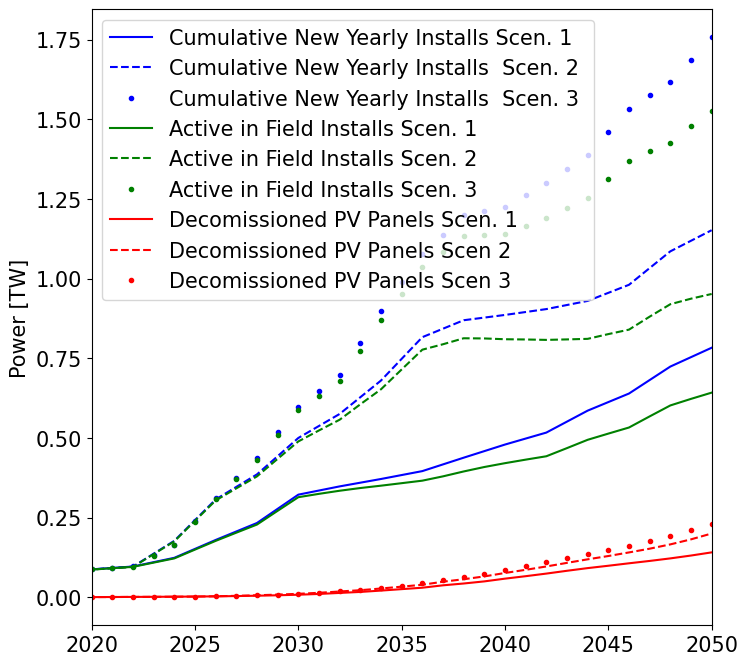

In [54]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 8)

fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6, 'b', label='Cumulative New Yearly Installs Scen. 1 ')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[1]]/1e6, 'b--', label='Cumulative New Yearly Installs  Scen. 2 ')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6, 'b.', label='Cumulative New Yearly Installs  Scen. 3 ')
axs.plot(USyearly['Capacity_'+SFscenarios[0]]/1e12, 'g', label='Active in Field Installs Scen. 1')
axs.plot(USyearly['Capacity_'+SFscenarios[1]]/1e12, 'g--', label='Active in Field Installs Scen. 2')
axs.plot(USyearly['Capacity_'+SFscenarios[2]]/1e12, 'g.', label='Active in Field Installs Scen. 3')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12, 'r', label='Decomissioned PV Panels Scen. 1')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[1]]/1e6-USyearly['Capacity_'+SFscenarios[1]]/1e12, 'r--', label='Decomissioned PV Panels Scen 2')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6-USyearly['Capacity_'+SFscenarios[2]]/1e12, 'r.', label='Decomissioned PV Panels Scen 3')

axs.legend()
axs.set_xlim([2020,2050])
axs.set_ylabel('Power [TW]')
plt.show()

In [55]:
foo0 = (UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12).sum()
foo1 = (UScum['new_Installed_Capacity_[MW]'+SFscenarios[1]]/1e6-USyearly['Capacity_'+SFscenarios[1]]/1e12).sum()
foo2 = (UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6-USyearly['Capacity_'+SFscenarios[2]]/1e12).sum()
print(foo0, foo1, foo2)

1.3692474079346892 1.8234325025965232 2.0681043184189223


In [56]:
E = (UScum['new_Installed_Capacity_[MW]Reference.Mod']/1e6).sum()
F = (UScum['new_Installed_Capacity_[MW]Reference.Mod']/1e6-USyearly['Capacity_Reference.Mod']/1e12).sum()
print("Cumulative Installs", E)
print("Cumulative Waste", F)
print("Fraction of Decomisioned to Installed Cumulative by 2050", F/E)


Cumulative Installs 12.481579419861927
Cumulative Waste 1.3692474079346892
Fraction of Decomisioned to Installed Cumulative by 2050 0.10970145378843699


In [57]:
SFscenarios[1]

'95-by-35.Adv'

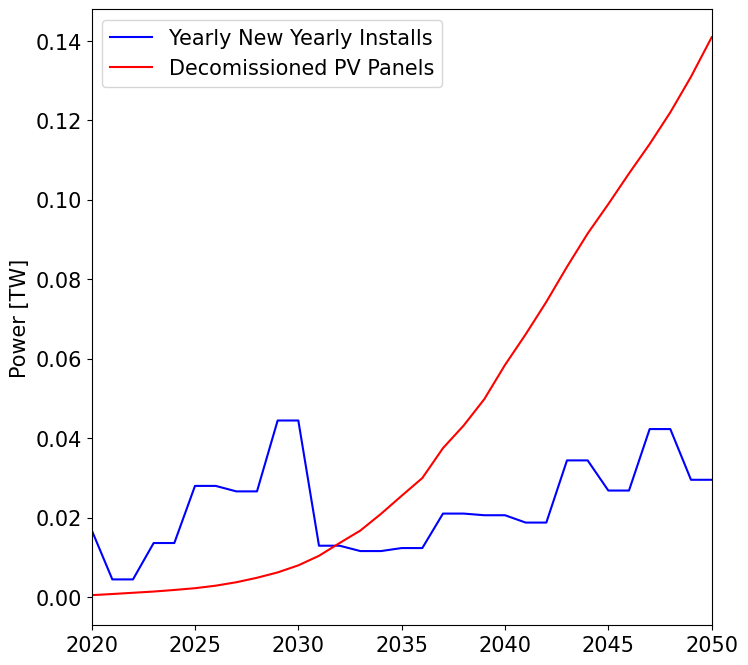

In [60]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 8)

fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(USyearly['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6, 'b', label='Yearly New Yearly Installs')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12, 'r', label='Decomissioned PV Panels')
axs.legend()
axs.set_xlim([2020,2050])
axs.set_ylabel('Power [TW]')
fig.savefig(title_Method+' Fig_New_Installs_vs_Decomisions', dpi=600)
plt.show()

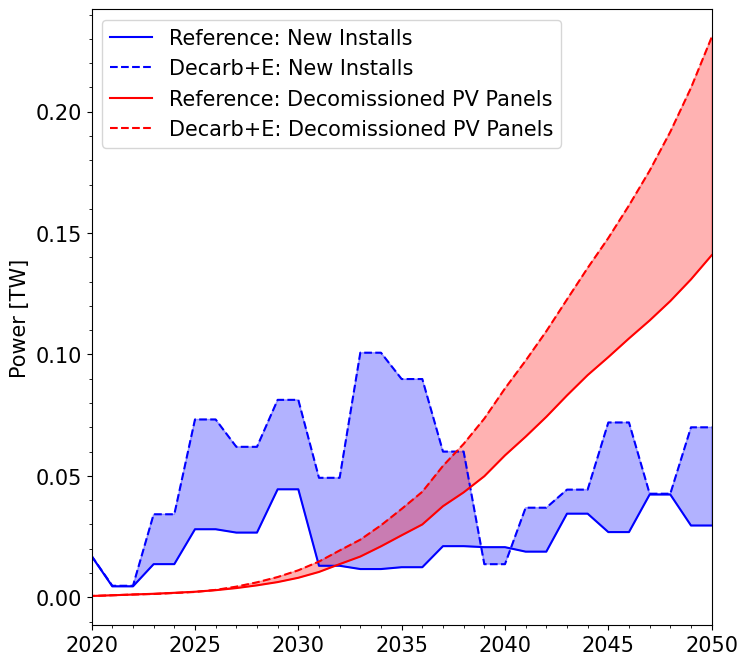

In [90]:
### SOLAR FUTURES FIGURE 20

plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 8)

fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(USyearly['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6, 'b', label='Reference: New Installs')
#axs.plot(USyearly['new_Installed_Capacity_[MW]'+SFscenarios[1]]/1e6, 'b', label='Grid Decarb.: Yearly New Yearly Installs')
axs.plot(USyearly['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6, 'b--', label='Decarb+E: New Installs')
axs.fill_between(rr.scenario[obj].data['year'], USyearly['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6,
                 USyearly['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6, color='b', alpha=0.3,
                 interpolate=True)


axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12, 'r', label='Reference: Decomissioned PV Panels')
axs.plot(UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6-USyearly['Capacity_'+SFscenarios[2]]/1e12, 'r--', label='Decarb+E: Decomissioned PV Panels')
axs.fill_between(rr.scenario[obj].data['year'], UScum['new_Installed_Capacity_[MW]'+SFscenarios[0]]/1e6-USyearly['Capacity_'+SFscenarios[0]]/1e12,
                UScum['new_Installed_Capacity_[MW]'+SFscenarios[2]]/1e6-USyearly['Capacity_'+SFscenarios[2]]/1e12, color='r', alpha=0.3,
                 interpolate=True)
axs.minorticks_on()


axs.legend()
axs.set_xlim([2020,2050])
axs.set_ylabel('Power [TW]')
fig.savefig(title_Method+' SF Figure 20 - New Installs vs Decomisions', dpi=600)
plt.show()

In [62]:
print("CUMULATIVE WASTE by 2050")
print("*************************")
print("")
UScum.iloc[-1]
print("MFG Scrap + EoL Material Only")
print("\t Reference Scenario: ", UScum['Waste_Module_Reference.Mod'].iloc[-1]/1e6, ' Million Tonnes')
print("\t Grid Decarbonization Scenario: ", UScum['Waste_Module_95-by-35.Adv'].iloc[-1]/1e6, ' Million Tonnes')
print("\t High Electrification Scenario: ", UScum['Waste_Module_95-by-35_Elec.Adv_DR'].iloc[-1]/1e6, ' Million Tonnes')

print("EoL Material Only")
print("\t Reference Scenario: ", UScum['Waste_EOL_Module_Reference.Mod'].iloc[-1]/1e6, ' Million Tonnes')
print("\t Grid Decarbonization Scenario: ", UScum['Waste_EOL_Module_95-by-35.Adv'].iloc[-1]/1e6, ' Million Tonnes')
print("\t High Electrification Scenario: ", UScum['Waste_EOL_Module_95-by-35_Elec.Adv_DR'].iloc[-1]/1e6, ' Million Tonnes')

print("MFG Scrap Only")
print("\t Reference Scenario: ", UScum['Waste_MFG_Module_Reference.Mod'].iloc[-1]/1e6, ' Million Tonnes')
print("\t Grid Decarbonization Scenario: ", UScum['Waste_MFG_Module_95-by-35.Adv'].iloc[-1]/1e6, ' Million Tonnes')
print("\t High Electrification Scenario: ", UScum['Waste_MFG_Module_95-by-35_Elec.Adv_DR'].iloc[-1]/1e6, ' Million Tonnes')

plt.show()

CUMULATIVE WASTE by 2050
*************************

MFG Scrap + EoL Material Only
	 Reference Scenario:  7.598873807149782  Million Tonnes
	 Grid Decarbonization Scenario:  9.720686125963702  Million Tonnes
	 High Electrification Scenario:  10.839108143474517  Million Tonnes
EoL Material Only
	 Reference Scenario:  5.768846179490254  Million Tonnes
	 Grid Decarbonization Scenario:  7.081040756363472  Million Tonnes
	 High Electrification Scenario:  7.05823473941935  Million Tonnes
MFG Scrap Only
	 Reference Scenario:  1.8300276276595273  Million Tonnes
	 Grid Decarbonization Scenario:  2.63964536960023  Million Tonnes
	 High Electrification Scenario:  3.780873404055167  Million Tonnes


In [63]:
print(" VIRGIN STOCK Yearly Needs ")
print(" **************************")
for kk in range(0, 3):
    obj = SFscenarios[kk]
    print(obj)
    filter_col = [col for col in USyearly3sig if (col.startswith('VirginStock_') and col.endswith(obj)) ]
    display(USyearly3sig[filter_col].loc[[2030, 2040, 2050]])
    print("\n\n")
    
print(" VIRGIN STOCK Cumulative Needs ")
print(" ***************************** ")
for kk in range(0, 3):
    obj = SFscenarios[kk]
    print(obj)
    filter_col = [col for col in UScum3sig if (col.startswith('VirginStock_') and col.endswith(obj)) ]
    display(UScum3sig[filter_col].loc[[2030, 2040, 2050]])
    print("\n\n")
    
    

 VIRGIN STOCK Yearly Needs 
 **************************
Reference.Mod


,VirginStock_glass_Reference.Mod,VirginStock_silicon_Reference.Mod,VirginStock_silver_Reference.Mod,VirginStock_copper_Reference.Mod,VirginStock_aluminum_Reference.Mod,VirginStock_Module_Reference.Mod
year,,,,,,
2030,1810000,85700,453,1480,206000,2100000
2040,799000,37900,200,657,91100,929000
2050,1110000,52800,279,915,127000,1290000





95-by-35.Adv


,VirginStock_glass_95-by-35.Adv,VirginStock_silicon_95-by-35.Adv,VirginStock_silver_95-by-35.Adv,VirginStock_copper_95-by-35.Adv,VirginStock_aluminum_95-by-35.Adv,VirginStock_Module_95-by-35.Adv
year,,,,,,
2030,2320000,110000,582,1910,264000,2700000
2040,322000,15300,80,265,36700,375000
2050,1250000,59300,313,1030,142000,1450000





95-by-35_Elec.Adv_DR


,VirginStock_glass_95-by-35_Elec.Adv_DR,VirginStock_silicon_95-by-35_Elec.Adv_DR,VirginStock_silver_95-by-35_Elec.Adv_DR,VirginStock_copper_95-by-35_Elec.Adv_DR,VirginStock_aluminum_95-by-35_Elec.Adv_DR,VirginStock_Module_95-by-35_Elec.Adv_DR
year,,,,,,
2030,3300000,157000,828,2710,376000,3840000
2040,528000,25000,132,434,60100,613000
2050,2640000,125000,661,2170,300000,3060000





 VIRGIN STOCK Cumulative Needs 
 ***************************** 
Reference.Mod


,VirginStock_glass_Reference.Mod,VirginStock_silicon_Reference.Mod,VirginStock_silver_Reference.Mod,VirginStock_copper_Reference.Mod,VirginStock_aluminum_Reference.Mod,VirginStock_Module_Reference.Mod
year,,,,,,
2030,14100000,847000,5970,12700,1920000,16800000
2040,20200000,1140000,7520,17800,2620000,24000000
2050,31800000,1690000,10400,27300,3940000,37500000





95-by-35.Adv


,VirginStock_glass_95-by-35.Adv,VirginStock_silicon_95-by-35.Adv,VirginStock_silver_95-by-35.Adv,VirginStock_copper_95-by-35.Adv,VirginStock_aluminum_95-by-35.Adv,VirginStock_Module_95-by-35.Adv
year,,,,,,
2030,21500000,1240000,8450,19900,2850000,25600000
2040,36800000,1960000,12300,32500,4590000,43400000
2050,46900000,2440000,14800,40800,5740000,55100000





95-by-35_Elec.Adv_DR


,VirginStock_glass_95-by-35_Elec.Adv_DR,VirginStock_silicon_95-by-35_Elec.Adv_DR,VirginStock_silver_95-by-35_Elec.Adv_DR,VirginStock_copper_95-by-35_Elec.Adv_DR,VirginStock_aluminum_95-by-35_Elec.Adv_DR,VirginStock_Module_95-by-35_Elec.Adv_DR
year,,,,,,
2030,25500000,1430000,9570,23400,3320000,30300000
2040,50300000,2610000,15800,43800,6150000,59100000
2050,70600000,3570000,20900,60500,8460000,82700000


In [64]:
print(" WASTE EoL CUMULATIVE RESULTS [Tonnes] ")
print(" ******************************************")
filter_col = [col for col in UScum3sig if (col.startswith('Waste_EOL_Module')) ]
display(UScum3sig[filter_col].loc[[2016,2020,2030, 2040, 2050]])


 WASTE EoL CUMULATIVE RESULTS [Tonnes] 
 ******************************************


,Waste_EOL_Module_Reference.Mod,Waste_EOL_Module_95-by-35.Adv,Waste_EOL_Module_95-by-35_Elec.Adv_DR
year,,,
2016,11,11,11
2020,643,643,643
2030,165000,165000,165000
2040,2370000,2380000,2380000
2050,5770000,7080000,7060000


In [66]:
print(" WASTE EoL + MfgScrap CUMULATIVE RESULTS [Tonnes] ")
print(" ******************************************")
filter_col = [col for col in UScum3sig if (col.startswith('Waste_Module')) ]
display(UScum3sig[filter_col].loc[[2016,2020,2030, 2040, 2050]])


 WASTE EoL + MfgScrap CUMULATIVE RESULTS [Tonnes] 
 ******************************************


,Waste_Module_Reference.Mod,Waste_Module_95-by-35.Adv,Waste_Module_95-by-35_Elec.Adv_DR
year,,,
2016,225000,225000,225000
2020,442000,440000,442000
2030,1150000,1600000,1810000
2040,3650000,4540000,5200000
2050,7600000,9720000,10800000


In [67]:
print(" WASTE MfgScrap CUMULATIVE RESULTS [Tonnes] ")
print(" ******************************************")
filter_col = [col for col in UScum3sig if (col.startswith('Waste_MFG_Module')) ]
display(UScum3sig[filter_col].loc[[2016,2020,2030, 2040, 2050]])


 WASTE MfgScrap CUMULATIVE RESULTS [Tonnes] 
 ******************************************


,Waste_MFG_Module_Reference.Mod,Waste_MFG_Module_95-by-35.Adv,Waste_MFG_Module_95-by-35_Elec.Adv_DR
year,,,
2016,225000,225000,225000
2020,441000,440000,442000
2030,987000,1430000,1640000
2040,1280000,2160000,2820000
2050,1830000,2640000,3780000


In [68]:
materials = ['Module', 'glass', 'aluminum', 'copper', 'silicon', 'silver']

print(" Appendix Table I: Metric Tonnes Installed in field in 2030")
print(" ########################################################### \n")
#Loop over scenarios
for kk in range (0, 3):
    obj = SFscenarios[kk]
    print("SCENARIO :", obj)

    print("********************************")
    print("********************************")

    modulemat = 0
    for ii in range(0, len(materials)):
        installedmat = (UScum3sig['VirginStock_'+materials[ii]+'_'+obj].loc[2030]-
              UScum3sig['Waste_'+materials[ii]+'_'+obj].loc[2030])
        print(materials[ii], ':', round(installedmat/1000)*1000, 'tons')

    print("Capacity in Year 2030 [GW]:", round(USyearly3sig['Capacity_'+obj].loc[2030]/1e9))
    print("Capacity in Year 2050 [GW]:", round(USyearly3sig['Capacity_'+obj].loc[2050]/1e9))
    print("****************************\n")

 Appendix Table I: Metric Tonnes Installed in field in 2030
 ########################################################### 

SCENARIO : Reference.Mod
********************************
********************************
Module : 15650000 tons
glass : 13355000 tons
aluminum : 1834000 tons
copper : 11000 tons
silicon : 530000 tons
silver : 5000 tons
Capacity in Year 2030 [GW]: 314
Capacity in Year 2050 [GW]: 642
****************************

SCENARIO : 95-by-35.Adv
********************************
********************************
Module : 24000000 tons
glass : 20460000 tons
aluminum : 2736000 tons
copper : 17000 tons
silicon : 799000 tons
silver : 6000 tons
Capacity in Year 2030 [GW]: 489
Capacity in Year 2050 [GW]: 952
****************************

SCENARIO : 95-by-35_Elec.Adv_DR
********************************
********************************
Module : 28490000 tons
glass : 24330000 tons
aluminum : 3192000 tons
copper : 21000 tons
silicon : 929000 tons
silver : 7000 tons
Capacity in Year 203

# Mining Capacity

In [69]:
mining2020_aluminum = 65267000
mining2020_silver = 22260
mining2020_copper = 20000000
mining2020_silicon = 8000000

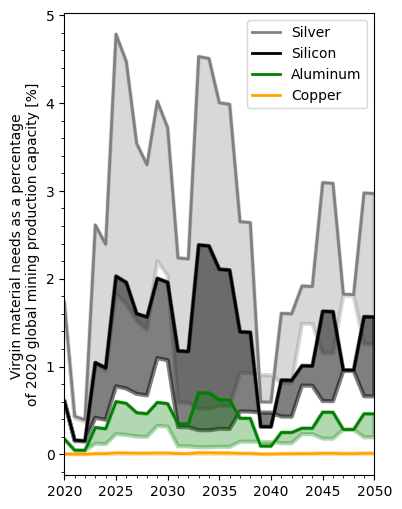

In [70]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (12, 8)
    
keywords=['VirginStock_']
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

fig, axs = plt.subplots(1,1, figsize=(4, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
i = 0

obj = SFscenarios[2]
# Loop over Keywords
ii = 0 
keyw = keywords[ii]
# Loop over SF Scenarios

# ROW 2, Aluminum and Silicon:        g-  4 aluminum k - 1 silicon   orange - 3 copper  gray - 2 silver
axs.plot(USyearly[keyw+materials[2]+'_'+SFscenarios[2]]*100/mining2020_silver, 
         color = 'gray', linewidth=2.0, label='Silver')
axs.fill_between(USyearly.index, USyearly[keyw+materials[2]+'_'+SFscenarios[0]]*100/mining2020_silver, 
                                 USyearly[keyw+materials[2]+'_'+SFscenarios[2]]*100/mining2020_silver,
                   color='gray', lw=3, alpha=.3)
    
axs.plot(USyearly[keyw+materials[1]+'_'+SFscenarios[2]]*100/mining2020_silicon, 
         color = 'k', linewidth=2.0, label='Silicon')
axs.fill_between(USyearly.index, USyearly[keyw+materials[1]+'_'+SFscenarios[0]]*100/mining2020_silicon, 
                                USyearly[keyw+materials[1]+'_'+SFscenarios[2]]*100/mining2020_silicon,
                   color='k', lw=3, alpha=.5)

axs.plot(USyearly[keyw+materials[4]+'_'+SFscenarios[2]]*100/mining2020_aluminum, 
         color = 'g', linewidth=2.0, label='Aluminum')

axs.fill_between(USyearly.index, USyearly[keyw+materials[4]+'_'+SFscenarios[0]]*100/mining2020_aluminum, 
                                USyearly[keyw+materials[4]+'_'+SFscenarios[2]]*100/mining2020_aluminum,
                   color='g', lw=3, alpha=.3)


axs.plot(USyearly[keyw+materials[3]+'_'+SFscenarios[2]]*100/mining2020_copper, 
         color = 'orange', linewidth=2.0, label='Copper')

axs.fill_between(USyearly.index, USyearly[keyw+materials[3]+'_'+SFscenarios[0]]*100/mining2020_copper, 
                                USyearly[keyw+materials[3]+'_'+SFscenarios[2]]*100/mining2020_copper,
                   color='orange', lw=3, alpha=.3)

axs.set_xlim([2020,2050])
axs.legend()
#axs.set_yscale('log')
axs.minorticks_on()

axs.set_ylabel('Virgin material needs as a percentage \nof 2020 global mining production capacity [%]')

fig.savefig(title_Method+' Fig_1x1_MaterialNeeds Ratio to Production.png',  bbox_inches = "tight", dpi=600)

plt.show()

In [71]:

keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

newdf = pd.DataFrame()


newdf['Silver_Ref'] = USyearly[keyw+materials[2]+'_'+SFscenarios[0]]*100/mining2020_silver
newdf['Silver_High'] = USyearly[keyw+materials[2]+'_'+SFscenarios[2]]*100/mining2020_silver
                  
    
    
newdf['Silicon_Ref'] = USyearly[keyw+materials[1]+'_'+SFscenarios[0]]*100/mining2020_silicon
newdf['Silicon_High'] = USyearly[keyw+materials[1]+'_'+SFscenarios[2]]*100/mining2020_silicon 
                  
    
newdf['Aluminium_Ref'] = USyearly[keyw+materials[4]+'_'+SFscenarios[0]]*100/mining2020_aluminum
newdf['Aluminum_High'] = USyearly[keyw+materials[4]+'_'+SFscenarios[2]]*100/mining2020_aluminum
                         
newdf['Copper_Ref'] = USyearly[keyw+materials[3]+'_'+SFscenarios[0]]*100/mining2020_copper
newdf['Copper_High'] = USyearly[keyw+materials[3]+'_'+SFscenarios[2]]*100/mining2020_copper

                        
newdf['Copper_Ref'] = USyearly[keyw+materials[3]+'_'+SFscenarios[0]]*100/mining2020_copper
newdf['Copper_High'] = USyearly[keyw+materials[3]+'_'+SFscenarios[2]]*100/mining2020_copper

newdf.to_csv(title_Method+' Demand as Percentage of Mining.csv')



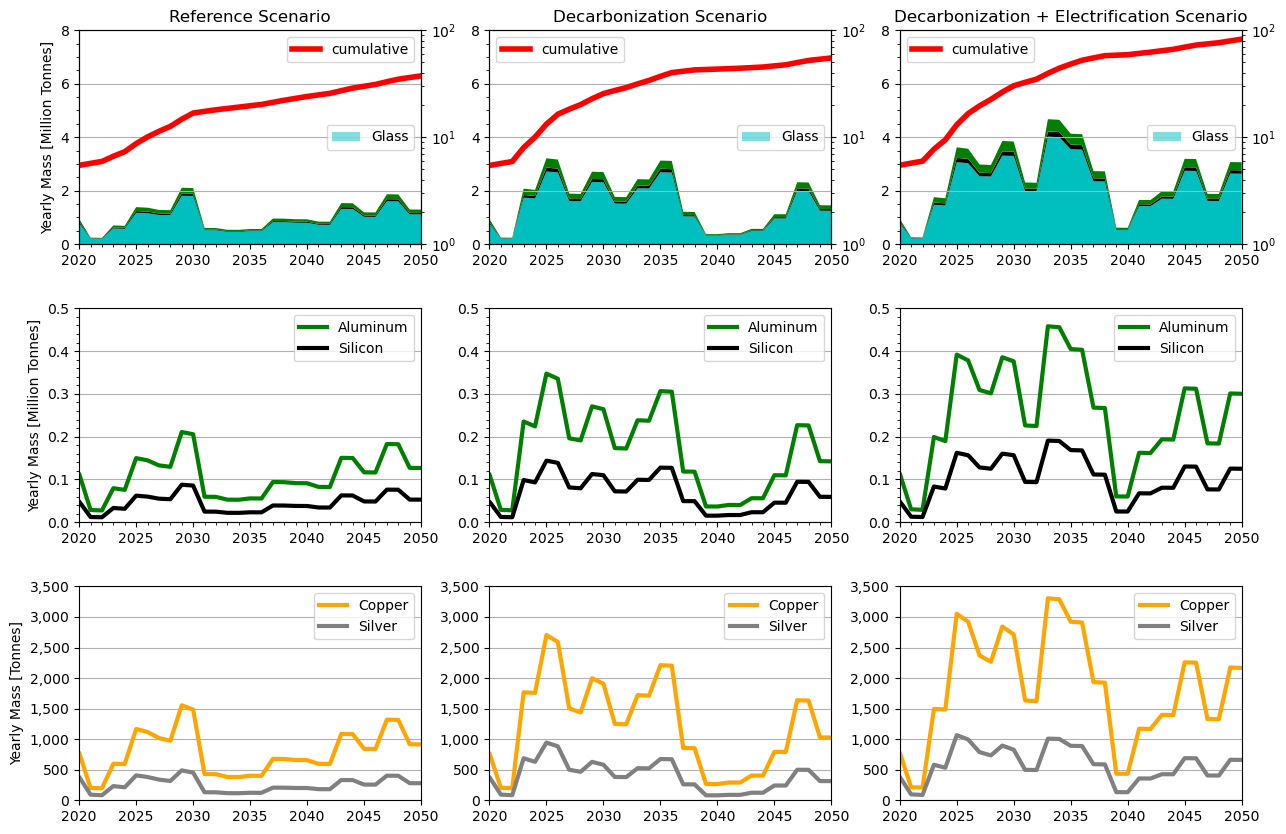

In [74]:
# FIGURE 4

import matplotlib as mpl

plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (12, 8)
    
keywords=['VirginStock_']
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
i = 0

# Loop over Keywords
ii = 0 
keyw = keywords[ii]
# Loop over SF Scenarios

titlesscens = ['Reference Scenario', 'Decarbonization Scenario', 'Decarbonization + Electrification Scenario']


for kk in range(0, 3):

    obj = SFscenarios[kk]
    axs[i].yaxis.grid()
    axs[i].axvspan(2000, 2018, facecolor='c', alpha=0.5, label='Glass')
#    axs[i].axvspan(2018, 2050.5, facecolor='yellow', alpha=0.1)
 #   axs[i].plot([],[],color='c', label='glass', linewidth=5)
 #   axs[i].plot([],[],color='k', label='silicon', linewidth=5)
 #   axs[i].plot([],[],color='m', label='silver', linewidth=5)
 #   axs[i].plot([],[],color='r', label='copper', linewidth=5)
 #   axs[i].plot([],[],color='g', label='aluminum', linewidth=5)

    axs[i].stackplot(rr.scenario[obj].data['year'], USyearly[keyw+materials[0]+'_'+obj]/1e6, 
                                                      USyearly[keyw+materials[1]+'_'+obj]/1e6, 
                                                      USyearly[keyw+materials[2]+'_'+obj]/1e6, 
                                                      USyearly[keyw+materials[3]+'_'+obj]/1e6, 
                                                      USyearly[keyw+materials[4]+'_'+obj]/1e6, 
                                                      colors=['c','k','gray','orange', 'g'])
    #axs[i].ylabel('Mass [Tons]')
    axs[i].set_xlim([2020, 2050])
    axs[i].set_title(titlesscens[kk])
    axs[i].legend(loc='center right')

    #axs[i].legend(materials)

    i += 1 

# 2nd axis plot
i = 0
for kk in range(0, 3):

    obj = SFscenarios[kk]
    ax2=axs[i].twinx()
    
    module = (UScum[keyw+materials[0]+'_'+obj]/1e6 + 
             UScum[keyw+materials[1]+'_'+obj]/1e6 + 
             UScum[keyw+materials[2]+'_'+obj]/1e6 +
             UScum[keyw+materials[3]+'_'+obj]/1e6 +
             UScum[keyw+materials[4]+'_'+obj]/1e6)
    ax2.plot(rr.scenario[obj].data['year'], module, 
             color = 'r', linewidth=4.0, label='cumulative')
    #axs[i].ylabel('Mass [Tons]')
 #   axs[i].set_xlim([2010, 2050])
  #  axs[i].set_title(keyw+ ' Yearly ' + obj.name)
    #axs[i].legend(materials)
    ax2.set_yscale('log')
#    ax2.set_ylim([1e3/1e6, 1e8/1e6])
    ax2.set_ylim([1e0, 1e2])

    i += 1 

    ax2.legend()


i = 3
# ROW 2, Aluminum and Silicon:
# Loop over SF Scenarios
for kk in range(0, 3):


    obj = SFscenarios[kk]
    axs[i].yaxis.grid()
#    axs[i].axvspan(2000, 2018, facecolor='0.9', alpha=0.5)

    axs[i].plot(rr.scenario[obj].data['year'], USyearly[keyw+materials[4]+'_'+obj]/1e6, color='g', lw=3, label='Aluminum')
 #   axs[i].fill_between(obj.scenario[STATEs[0]].data['year'], 0, USyearly[keyw+materials[4]+'_'+obj.name], 
 #                   color='g', lw=3, alpha=.6)
    
    axs[i].plot(rr.scenario[obj].data['year'], USyearly[keyw+materials[1]+'_'+obj]/1e6, color='k', lw=3, label='Silicon')
   # axs[i].fill_between(obj.scenario[STATEs[0]].data['year'], 0, USyearly[keyw+materials[1]+'_'+obj.name], 
   #                 color='k', lw=3)# alpha=.3)


    # silicon aluminum 'k ''g'
    #axs[i].ylabel('Mass [Tons]')
    axs[i].set_xlim([2020, 2050])
    #axs[i].set_title(keyw+ ' Yearly ' + obj.name)
    #axs[i].legend(materials)
    axs[i].legend()

    i += 1 



# ROW 3:
# Loop over SF Scenarios
for kk in range(0, 3):

    obj = SFscenarios[kk]
    axs[i].yaxis.grid()

    axs[i].plot(rr.scenario[obj].data['year'], USyearly[keyw+materials[3]+'_'+obj], color='orange', lw=3, label='Copper')
 #   axs[i].fill_between(obj.scenario[STATEs[0]].data['year'], 0, USyearly[keyw+materials[3]+'_'+obj.name], 
  #                  color='orange', lw=3)# alpha=.3)

    axs[i].plot(rr.scenario[obj].data['year'], USyearly[keyw+materials[2]+'_'+obj], color='gray', lw=3, label='Silver')
 #   axs[i].fill_between(obj.scenario[STATEs[0]].data['year'], 0, USyearly[keyw+materials[2]+'_'+obj.name], 
 #                   color='gray', lw=3)# , alpha=.6)
    
    
    #axs[i].ylabel('Mass [Tons]')
    axs[i].set_xlim([2020, 2050])
    #axs[i].set_title(keyw+ ' Yearly ' + obj.name)
    axs[i].legend()
    axs[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    i += 1 
    
for i in range (0, 3):
    axs[i].set_ylim([0, 0.8e7/1e6])
    axs[i].minorticks_on()

    #a0.tick_params(axis='y', which='minor', bottom=False)
    #    axs[i].set_ylim([0, 1e7/1e6])
    
    axs[i+3].set_ylim([0, 0.5e6/1e6])
    axs[i+3].minorticks_on()

    axs[i+6].set_ylim([0, 3500])

    #axs[i+3].set_ylim([1e0, 10e8])
    #axs[i+6].set_ylim([1e0, 5e6])

#    axs[i+3].set_yscale('log')
#    axs[i+6].set_yscale('log')

axs[0].set_ylabel('Mass [Tons]')
axs[3].set_ylabel('Mass [Tons]')
#axs[5].legend(materials)
    
axs[0].set_ylabel('Yearly Mass [Million Tonnes]')
axs[3].set_ylabel('Yearly Mass [Million Tonnes]')
axs[6].set_ylabel('Yearly Mass [Tonnes]')

#axs[8].legend(materials)

fig.savefig(title_Method+' SF Figure 4 - MaterialNeeds Nation.png', dpi=600)
plt.show()

In [75]:
keyword='Cumulative_Area_disposed'

USyearly_Areadisp=pd.DataFrame()

# Loop over SF Scenarios
for kk in range(0, 3):
    obj = SFscenarios[kk]
    # Loop over Materials
    foo = rr.scenario[obj].data[keyword].copy()
    USyearly_Areadisp["Areadisp_"+obj] = foo

    # Loop over STATEs
    #for jj in range (1, len(STATEs)): 
     #   USyearly_Areadisp["Areadisp_"+obj] += rr.scenario[obj].data[keyword]



In [76]:
UScum_Areadisp = USyearly_Areadisp.copy()
UScum_Areadisp = UScum_Areadisp.cumsum()

In [77]:
A = UScum['Waste_Module_Reference.Mod'].iloc[-1]
#47700000 # tonnes cumulative by 2050
A = A*1000 # convert to kg
A = A/10.05599 # convert to m2 if each m2 is ~avg 10 kg
#A = A*2 # convert to area if each module is ~2 m2
A = A/1e6 # Convert to km 2
print(A)

755.6564601943501


In [78]:
B = UScum['Waste_Module_95-by-35_Elec.Adv_DR'].iloc[-1]
#47700000 # tonnes cumulative by 2050
B = B*1000 # convert to kg
B= B/10.05599 # convert to m2 if each m2 is ~avg 10 kg
#A = A*2 # convert to area if each module is ~2 m2
B =B/1e6 # Convert to km 2
print(B)

1077.8757878114952


In [79]:
C = UScum_Areadisp['Areadisp_Reference.Mod'].iloc[-1]/1e6
D = UScum_Areadisp['Areadisp_95-by-35_Elec.Adv_DR'].iloc[-1]/1e6

In [80]:
# MANHATTAN SIZE:
manhattans = 59.103529

In [81]:
print("Reference Cumulative Area by 2050 of Waste PV Modules EoL", round(C), " km^2")
print("High Electrification Cumulative Area by 2050 of Waste PV Modules EoL", round(D), " km^2")


print("")
print("Reference Waste equals ", round(C/manhattans), " Manhattans ")
print("High Electrification equals ", round(D/manhattans), " Manhattans ")

print("")
print ("MFG SCrap + Eol Waste")
print("Reference Cumulative Area by 2050 of Waste PV Mfg + Modules EoL", round(A), " km^2")
print("High Electrification Cumulative Area by 2050 of Waste PV Mfg + Modules EoL", round(B), " km^$")

Reference Cumulative Area by 2050 of Waste PV Modules EoL 560  km^2
High Electrification Cumulative Area by 2050 of Waste PV Modules EoL 683  km^2

Reference Waste equals  9  Manhattans 
High Electrification equals  12  Manhattans 

MFG SCrap + Eol Waste
Reference Cumulative Area by 2050 of Waste PV Mfg + Modules EoL 756  km^2
High Electrification Cumulative Area by 2050 of Waste PV Mfg + Modules EoL 1078  km^$


### New Section

VirginStock_aluminum_Reference.Mod
VirginStock_aluminum_95-by-35.Adv  
VirginStock_aluminum_95-by-35_Elec.Adv_DR 
Waste_EOL_aluminum_Reference.Mod  
Waste_EOL_aluminum_95-by-35.Adv  
Waste_EOL_aluminum_95-by-35_Elec.Adv_DR  

VirginStock_silver_Reference.Mod
VirginStock_silver_95-by-35.Adv  
VirginStock_silver_95-by-35_Elec.Adv_DR 
Waste_EOL_silver_Reference.Mod  
Waste_EOL_silver_95-by-35.Adv  
Waste_EOL_silver_95-by-35_Elec.Adv_DR  


In [82]:
USyearly['VirginStock_silver_Reference.Mod']

year
2010    128.426774
2011    219.915502
2012    172.505147
2013    234.947057
2014    214.149815
2015    321.420822
2016    283.204082
2017    269.165286
2018    273.761119
2019    465.757234
2020    382.744131
2021     91.373232
2022     82.747506
2023    231.970049
2024    212.484190
2025    407.290500
2026    380.662842
2027    338.591666
2028    315.521303
2029    489.351669
2030    452.797028
2031    131.150695
2032    130.404439
2033    116.233802
2034    115.657615
2035    122.605382
2036    122.066957
2037    206.839493
2038    206.024174
2039    201.195632
2040    200.476230
2041    181.903956
2042    181.308816
2043    331.327899
2044    330.328800
2045    256.781267
2046    256.063206
2047    402.562428
2048    401.512942
2049    279.696766
2050    279.013840
Name: VirginStock_silver_Reference.Mod, dtype: float64

In [ ]:
USyearly

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12, 8)
    
fig, axs = plt.subplots(1,3, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.6)
axs = axs.ravel()

# PLOT 1
i = 0
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_silver_Reference.Mod']/1e6, color='gray', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_silver_Reference.Mod']/1e6, color='gray', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Silver')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_silver_Reference.Mod']/USyearly['VirginStock_silver_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='Eol Material as fraction of Demand')
ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
#axs[0].legend(lns, labs, loc=0)

# PLOT 2
i = 1
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_aluminum_Reference.Mod']/1e6, color='g', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_aluminum_Reference.Mod']/1e6, color='g', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Aluminum')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_aluminum_Reference.Mod']/USyearly['VirginStock_aluminum_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='Eol Material as fraction of Demand')

ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
#axs[1].legend(lns, labs, loc=0)



# PLOT 3
i = 2
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_silicon_Reference.Mod']/1e6, color='k', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_silicon_Reference.Mod']/1e6, color='k', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Silicon')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_silicon_Reference.Mod']/USyearly['VirginStock_silicon_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='Eol Material as fraction of Demand')

#ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
axs[2].legend(lns, labs, loc='upper center', bbox_to_anchor=(-0.95, -0.25),
          fancybox=True, shadow=True, ncol=5)

fig.savefig(title_Method+' Fig_1x3_VirginvsWaste_Fraction_Nation.png', bbox_inches = "tight", dpi=600)

In [ ]:
from matplotlib.legend_handler import HandlerBase

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12, 8)

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        
        if orig_handle[0] is 'r':
            l1 = plt.Line2D([x0,y0+width], [0.4*height,0.4*height], color=orig_handle[0])
            return [l1]

        else:

            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], color=orig_handle[0], linestyle = orig_handle[3],)
            l2 = plt.Line2D([x0,y0+width], [0.4*height,0.4*height], color=orig_handle[1], linestyle = orig_handle[4])
            l3 = plt.Line2D([x0,y0+width], [0.1*height,0.1*height], color=orig_handle[2], linestyle = orig_handle[5])
        
        return [l1, l2, l3]

    
    
fig, axs = plt.subplots(1,3, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.6)
axs = axs.ravel()

# PLOT 1
i = 0
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_silver_Reference.Mod']/1e6, color='gray', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_silver_Reference.Mod']/1e6, color='gray', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Silver')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_silver_Reference.Mod']/USyearly['VirginStock_silver_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='Eol Material as fraction of Demand')
ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
#axs[0].legend(lns, labs, loc=0)

# PLOT 2
i = 1
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_aluminum_Reference.Mod']/1e6, color='g', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_aluminum_Reference.Mod']/1e6, color='g', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Aluminum')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_aluminum_Reference.Mod']/USyearly['VirginStock_aluminum_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='Eol Material as fraction of Demand')

ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
#axs[1].legend(lns, labs, loc=0)



# PLOT 3
i = 2
axs[i].yaxis.grid()
lns1 = axs[i].plot(USyearly.index, USyearly['VirginStock_silicon_Reference.Mod']/1e6, color='k', linewidth=4.0, label='Virgin Material Demands')
lns2 = axs[i].plot(USyearly.index, USyearly['Waste_EOL_silicon_Reference.Mod']/1e6, color='k', linestyle='dashed', linewidth=3.0, label='EoL Material')
axs[i].set_ylabel('Mass [Tons]')
axs[i].set_xlim([2020, 2050])
axs[i].set_title('Silicon')

# 2nd axis plot
ax2=axs[i].twinx()
lns3 = ax2.plot(USyearly.index, USyearly['Waste_EOL_silicon_Reference.Mod']/USyearly['VirginStock_silicon_Reference.Mod'], 
             color = 'r', linewidth=1.0, label='EOl Material as fraction of Demand')

#ax2.set_ylabel('EoL Material as Fraction of Demand', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# LEGENDS
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
#axs[2].legend(lns, labs, loc='upper center', bbox_to_anchor=(-0.95, -0.25),
#          fancybox=True, shadow=True, ncol=5) 

#axs[2].legend([("gray","g","k","-","-","-"), ("gray","g","k","--","--","--"),("r","r","r","-","-","-")], ['Material Demands', "EoL Material", 'Fraction'],
#           handler_map={tuple: AnyObjectHandler()}, loc='upper center', bbox_to_anchor=(-0.95, -0.25),
#          fancybox=True, shadow=True, ncol=5)

axs[2].legend([("gray","g","k","-","-","-"), ("gray","g","k","--","--","--"),("r","r","r")], [' Virgin material demands', "EOL material", 'EOL material as fraction of demand'],
           handler_map={tuple: AnyObjectHandler()}, loc='upper center', bbox_to_anchor=(-0.95, -0.25),
          fancybox=True, shadow=True, ncol=5)

fig.savefig(title_Method+' Fig_1x3_VirginvsWaste_Fraction_Nation.png', bbox_inches = "tight", dpi=600)

In [ ]:
newdf = pd.DataFrame()

newdf['Virgin material demands, Silicon, Reference'] = USyearly['VirginStock_silicon_Reference.Mod']/1e6 
newdf['EOL material, Silicon, Reference'] = USyearly['Waste_EOL_silicon_Reference.Mod']/1e6
newdf['EOL material as fraction of demand, Silicon, Reference'] = USyearly['Waste_EOL_silicon_Reference.Mod']/USyearly['VirginStock_silicon_Reference.Mod']

newdf['Virgin material demands, Silver, Reference'] = USyearly['VirginStock_silver_Reference.Mod']/1e6 
newdf['EOL material, Silver, Reference'] = USyearly['Waste_EOL_silver_Reference.Mod']/1e6
newdf['EOL material as fraction of demand, Silver, Reference'] = USyearly['Waste_EOL_silver_Reference.Mod']/USyearly['VirginStock_silver_Reference.Mod']

newdf['Virgin material demands, Aluminum, Reference'] = USyearly['VirginStock_aluminum_Reference.Mod']/1e6 
newdf['EOL material, Aluminum, Reference'] = USyearly['Waste_EOL_aluminum_Reference.Mod']/1e6
newdf['EOL material as fraction of demand, Aluminum, Reference'] = USyearly['Waste_EOL_aluminum_Reference.Mod']/USyearly['VirginStock_aluminum_Reference.Mod']


newdf['Virgin material demands, Silicon, Grid Decarb.'] = USyearly['VirginStock_silicon_'+SFscenarios[1]]/1e6 
newdf['EOL material, Silicon, Grid Decarb.'] = USyearly['Waste_EOL_silicon_'+SFscenarios[1]]/1e6
newdf['EOL material as fraction of demand, Silicon, Grid Decarb.'] = USyearly['Waste_EOL_silicon_'+SFscenarios[1]]/USyearly['VirginStock_silicon_'+SFscenarios[1]]

newdf['Virgin material demands, Silver, Grid Decarb.'] = USyearly['VirginStock_silver_'+SFscenarios[1]]/1e6 
newdf['EOL material, Silver, Grid Decarb.'] = USyearly['Waste_EOL_silver_'+SFscenarios[1]]/1e6
newdf['EOL material as fraction of demand, Silver, Grid Decarb.'] = USyearly['Waste_EOL_silver_'+SFscenarios[1]]/USyearly['VirginStock_silver_'+SFscenarios[1]]

newdf['Virgin material demands, Aluminum, Grid Decarb.'] = USyearly['VirginStock_aluminum_'+SFscenarios[1]]/1e6 
newdf['EOL material, Aluminum, Grid Decarb.'] = USyearly['Waste_EOL_aluminum_'+SFscenarios[1]]/1e6
newdf['EOL material as fraction of demand, Aluminum, Grid Decarb.'] = USyearly['Waste_EOL_aluminum_'+SFscenarios[1]]/USyearly['VirginStock_aluminum_'+SFscenarios[1]]


newdf['Virgin material demands, Silicon, High Elec.'] = USyearly['VirginStock_silicon_'+SFscenarios[2]]/1e6 
newdf['EOL material, Silicon, High Elec.'] = USyearly['Waste_EOL_silicon_'+SFscenarios[2]]/1e6
newdf['EOL material as fraction of demand, Silicon, High Elec.'] = USyearly['Waste_EOL_silicon_'+SFscenarios[2]]/USyearly['VirginStock_silicon_'+SFscenarios[2]]

newdf['Virgin material demands, Silver, High Elec.'] = USyearly['VirginStock_silver_'+SFscenarios[2]]/1e6 
newdf['EOL material, Silver, High Elec.'] = USyearly['Waste_EOL_silver_'+SFscenarios[2]]/1e6
newdf['EOL material as fraction of demand, Silver, High Elec.'] = USyearly['Waste_EOL_silver_'+SFscenarios[2]]/USyearly['VirginStock_silver_'+SFscenarios[2]]

newdf['Virgin material demands, Aluminum, High Elec.'] = USyearly['VirginStock_aluminum_'+SFscenarios[2]]/1e6 
newdf['EOL material, Aluminum, High Elec.'] = USyearly['Waste_EOL_aluminum_'+SFscenarios[2]]/1e6
newdf['EOL material as fraction of demand, Aluminum, High Elec.'] = USyearly['Waste_EOL_aluminum_'+SFscenarios[2]]/USyearly['VirginStock_aluminum_'+SFscenarios[2]]

newdf.to_csv(title_Method+' Demand vs EOL Fraction NATION.csv')
